# Chamber Analysis - Interactive Notebook

Dieses Notebook führt die Kammer-Analyse Schritt für Schritt durch und zeigt alle Zwischenergebnisse an.

## 1. Imports und Setup

In [1]:
import json
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os
from ipyfilechooser import FileChooser

# Import functions from chamber_analyzer_json
from chamber_analyzer_json import (
    load_json_data,
    create_mesh_from_json,
    mesh_to_voxels,
    voxels_to_depth_image_custom_direction,
    create_object_boundary_mask,
    detect_contours_from_depth,
    calculate_chamber_center_for_point,
    plot_contours,
    close_contours_with_boundary,
    filter_nested_contours_with_hierarchy
)

# Matplotlib inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 2. Wähle JSON-Datei

In [23]:
# Wähle JSON-Datei mit interaktivem FileChooser
fc = FileChooser('C:/Users/LocalUser/Desktop/ConnectionPoins/DataSet')
fc.filter_pattern = '*.json'
fc.title = 'Wähle JSON-Datei für Analyse:'
fc.show_only_dirs = False
display(fc)

FileChooser(path='C:\Users\LocalUser\Desktop\ConnectionPoins\DataSet', filename='', title='Wähle JSON-Datei fü…

### Datei laden (führe diese Cell nach Auswahl aus)

In [223]:
# Lade ausgewählte Datei
json_file_path = fc.selected

if json_file_path is None or json_file_path == '':
    raise ValueError("Keine Datei ausgewählt! Bitte wähle eine JSON-Datei aus.")

print(f"Ausgewählte Datei: {json_file_path}")

# Lade Daten
part_data = load_json_data(json_file_path)

print(f"PartNr: {part_data.get('PartNr', 'unknown')}")
print(f"ConnectionPoints: {len(part_data.get('ConnectionPoints', []))}")
print(f"Points in Mesh: {len(part_data.get('Graphic3d', {}).get('Points', []))}")
print(f"Indices in Mesh: {len(part_data.get('Graphic3d', {}).get('Indices', []))}")

Ausgewählte Datei: C:\Users\LocalUser\Desktop\ConnectionPoins\DataSet\PXC.3036563_ElectricalTerminal_ElectricalTerminal.json
Loaded: PXC.3036563 - 885 points, 2 connection points
PartNr: PXC.3036563
ConnectionPoints: 2
Points in Mesh: 885
Indices in Mesh: 5310


## 3. Erstelle Mesh und Voxelisierung

In [224]:
# Erstelle Mesh aus JSON
mesh = create_mesh_from_json(part_data)
print(f"Mesh created: {len(mesh.vertices)} vertices, {len(mesh.triangles)} triangles")

# Konvertiere zu Voxeln
voxel_resolution = 800
print(f"\nVoxelizing mesh with resolution {voxel_resolution}...")
voxel_grid = mesh_to_voxels(mesh, voxel_resolution=voxel_resolution)
print(f"Voxel grid created")

Created mesh: 885 vertices, 1770 faces
Mesh created: 885 vertices, 1770 triangles

Voxelizing mesh with resolution 800...
Converting mesh to voxels (resolution: 800)
Voxel size: 0.076918
Voxel grid created: 1267475 voxels
Voxel grid created


## 4. Wähle Connection Point für Analyse

In [225]:
# Liste alle Connection Points
connection_points = part_data.get('ConnectionPoints', [])
for cp in connection_points:
    print(f"CP {cp['Index']}: {cp['Name']} - Position: ({cp['Point']['X']:.2f}, {cp['Point']['Y']:.2f}, {cp['Point']['Z']:.2f})")

# Wähle Connection Point für Analyse
cp_index = 0  # Ändere dies für andere Connection Points
cp = connection_points[cp_index]

print(f"\n=== Analyzing CP {cp['Index']}: {cp['Name']} ===")

CP 0:  - Position: (7.20, 13.80, -1.90)
CP 1:  - Position: (-40.70, 13.80, -1.90)

=== Analyzing CP 0:  ===


## 5. Erstelle Tiefenbild

InsertDirection: [0.000, 1.000, 0.000]
Creating depth image in direction [0.000, 1.000, 0.000]
  Region: 50.0mm x 50.0mm um Anschlusspunkt
  Filtered voxels: 621307 / 1267475 (49.0%)
  Depth image resolution: 652 x 652
  Depth image created: (652, 652), 7.9% coverage


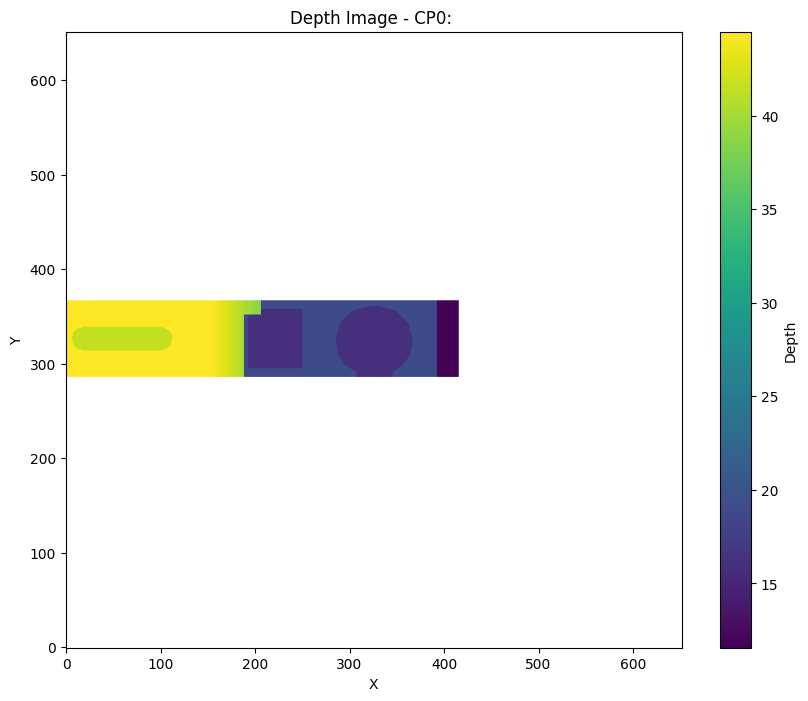

Depth image shape: (652, 652)
Extent: U=[-17.80, 32.20], V=[-23.10, 26.90]


In [226]:
# Lese InsertDirection
insert_dir = cp.get('InsertDirection', {'X': 0.0, 'Y': 0.0, 'Z': 1.0})
direction_vector = np.array([insert_dir['X'], insert_dir['Y'], insert_dir['Z']])
direction_vector = direction_vector / np.linalg.norm(direction_vector)

print(f"InsertDirection: [{direction_vector[0]:.3f}, {direction_vector[1]:.3f}, {direction_vector[2]:.3f}]")

# Lese Connection Point Position
cp_pos = cp.get('Point', {'X': 0.0, 'Y': 0.0, 'Z': 0.0})
connection_point_pos = np.array([cp_pos['X'], cp_pos['Y'], cp_pos['Z']])

# Erstelle Tiefenbild (10mm x 10mm Region)
depth_image, extent = voxels_to_depth_image_custom_direction(
    voxel_grid,
    direction_vector,
    connection_point_pos,
    region_size_mm=50.0
)

# Visualisiere Tiefenbild
extent_tuple, transform_info = extent
depth_display = np.ma.masked_invalid(depth_image)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(depth_display, origin='lower', cmap='viridis')
im.cmap.set_bad(color='white')
plt.colorbar(im, ax=ax, label='Depth')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Depth Image - CP{cp["Index"]}: {cp["Name"]}')
plt.show()

print(f"Depth image shape: {depth_image.shape}")
print(f"Extent: U=[{extent_tuple[0]:.2f}, {extent_tuple[1]:.2f}], V=[{extent_tuple[2]:.2f}, {extent_tuple[3]:.2f}]")

## 6. Erstelle Object Boundary

boundary kernel
[[1 1 1]
 [1 1 1]
 [1 1 1]]


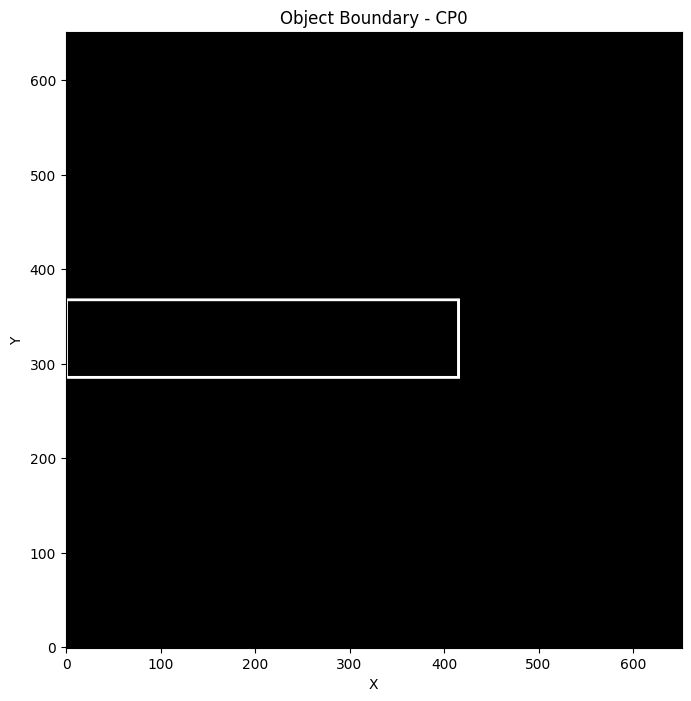

255
0


In [227]:
# Erstelle Object Boundary Mask
valid_mask = ~np.isnan(depth_image)

# Erweitere valid_mask um 1 Pixel (Dilation)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
print("boundary kernel")
print(kernel)
valid_dilated = cv2.dilate(valid_mask.astype(np.uint8), kernel, iterations=1)

# Rand = Pixel die in dilated sind, aber nicht in original
# Das sind NaN-Pixel mit gültigen Nachbarn
object_boundary = ((valid_dilated == 1) & (valid_mask == 0)).astype(np.uint8) * 255
object_boundary = cv2.dilate(object_boundary, kernel, iterations=1)

# Visualisiere
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(object_boundary, origin='lower', cmap='gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Object Boundary - CP{cp["Index"]}')
plt.show()


print(np.max(object_boundary))
print(np.min(object_boundary)) 

## 7. Berechne Gradienten

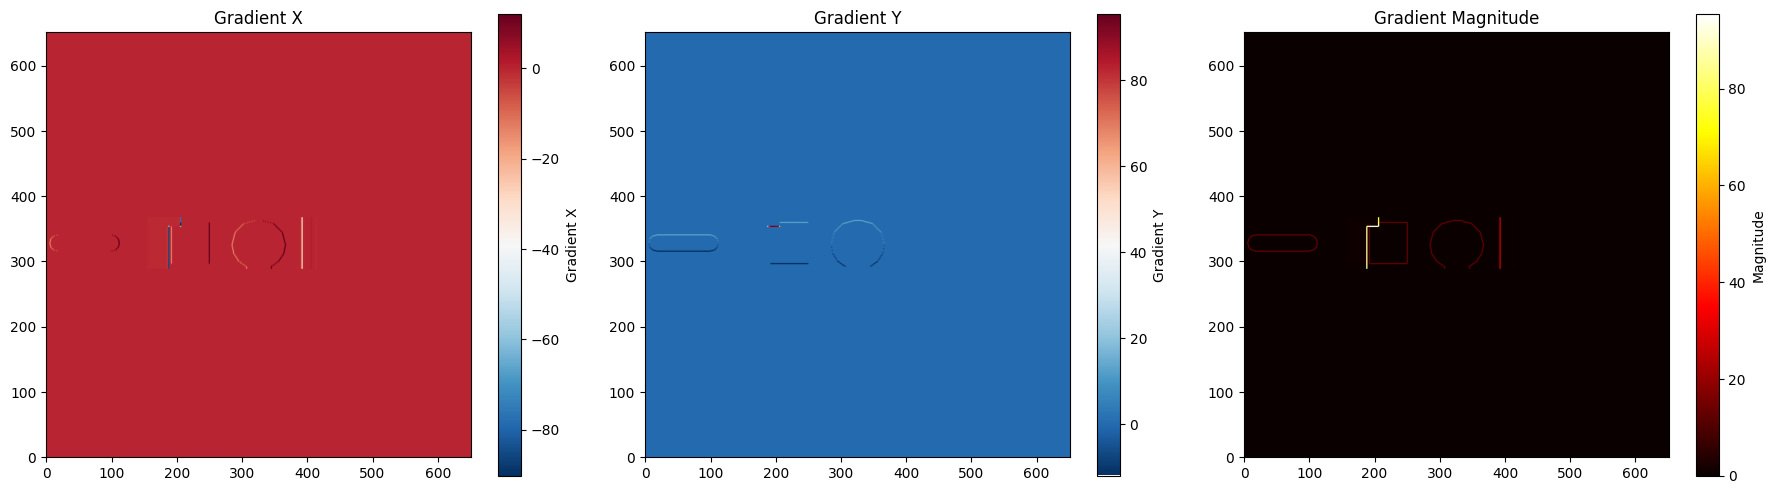

In [228]:
# Berechne Gradienten
valid_mask = ~np.isnan(depth_image)
depth_filled = depth_image.copy()
depth_filled[~valid_mask] = 0

grad_x = cv2.Sobel(depth_filled, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(depth_filled, cv2.CV_64F, 0, 1, ksize=3)

# Setze invalide Gradienten außerhalb des Objekts auf 0
grad_x[~valid_mask] = 0
grad_y[~valid_mask] = 0

# Setze Rand Gradienten auf 0
grad_x[object_boundary == 255] = 0
grad_y[object_boundary == 255] = 0

# calculate magnitute
gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
gradient_magnitude[~valid_mask] = 0

# Visualisiere alle drei
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im1 = axes[0].imshow(grad_x, origin='lower', cmap='RdBu_r')
plt.colorbar(im1, ax=axes[0], label='Gradient X')
axes[0].set_title('Gradient X')

im2 = axes[1].imshow(grad_y, origin='lower', cmap='RdBu_r')
plt.colorbar(im2, ax=axes[1], label='Gradient Y')
axes[1].set_title('Gradient Y')

im3 = axes[2].imshow(gradient_magnitude, origin='lower', cmap='hot')
plt.colorbar(im3, ax=axes[2], label='Magnitude')
axes[2].set_title('Gradient Magnitude')

plt.tight_layout()
plt.show()

## Binary Image

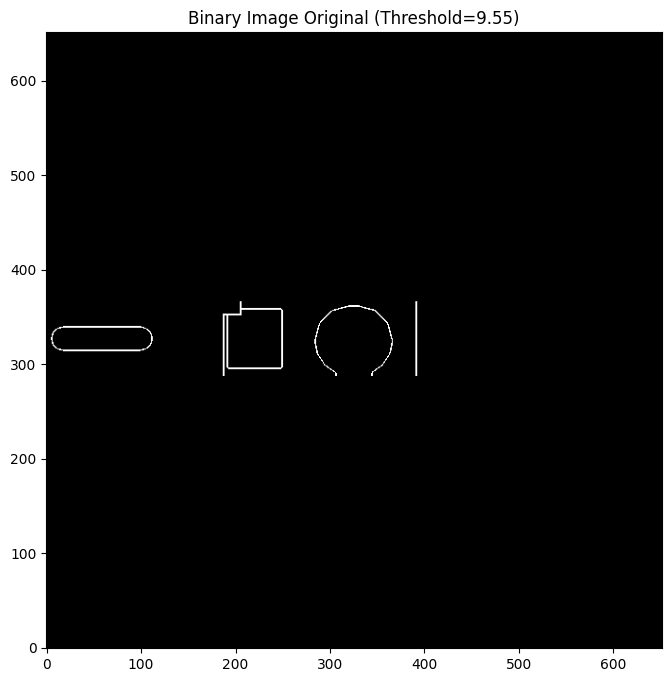

In [229]:
# Threshold für Binary Image
threshold_factor = 0.1
threshold = threshold_factor * np.max(gradient_magnitude)
binary_image = (gradient_magnitude > threshold).astype(np.uint8) * 255

# Visualisiere Binary Original
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(binary_image, origin='lower', cmap='gray')
ax.set_title(f'Binary Image Original (Threshold={threshold:.2f})')
plt.show()

## Show binary image & boundaries

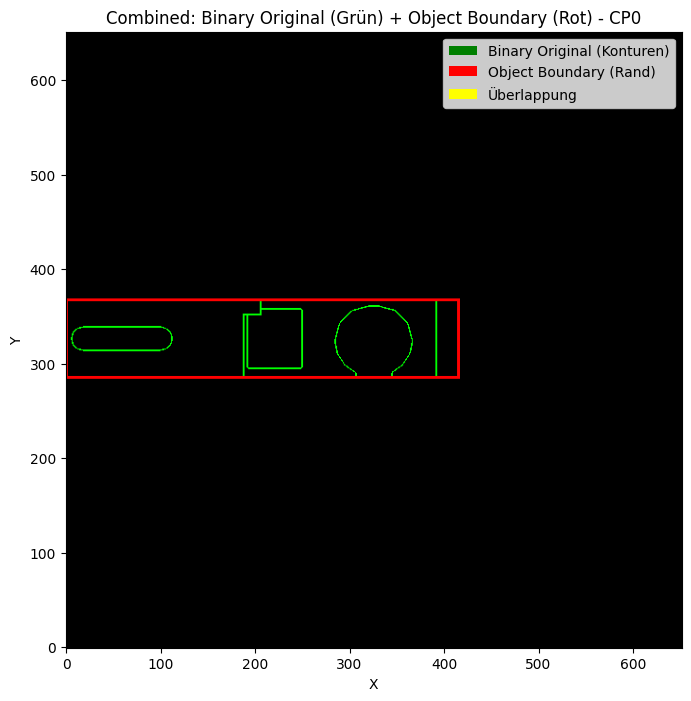

In [230]:
# Erstelle RGB Kombination
combined_image = np.zeros((binary_image.shape[0], binary_image.shape[1], 3), dtype=np.uint8)
combined_image[:, :, 1] = binary_image  # Grün (Kanal 1)
combined_image[:, :, 0] = object_boundary  # Rot (Kanal 0)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(combined_image, origin='lower')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Combined: Binary Original (Grün) + Object Boundary (Rot) - CP{cp["Index"]}')

legend_elements = [
    Patch(facecolor='green', label='Binary Original (Konturen)'),
    Patch(facecolor='red', label='Object Boundary (Rand)'),
    Patch(facecolor='yellow', label='Überlappung')
]
ax.legend(handles=legend_elements, loc='upper right')
plt.show()

## Contours

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Contours'}, xlabel='X (Pixel)', ylabel='Y (Pixel)'>)

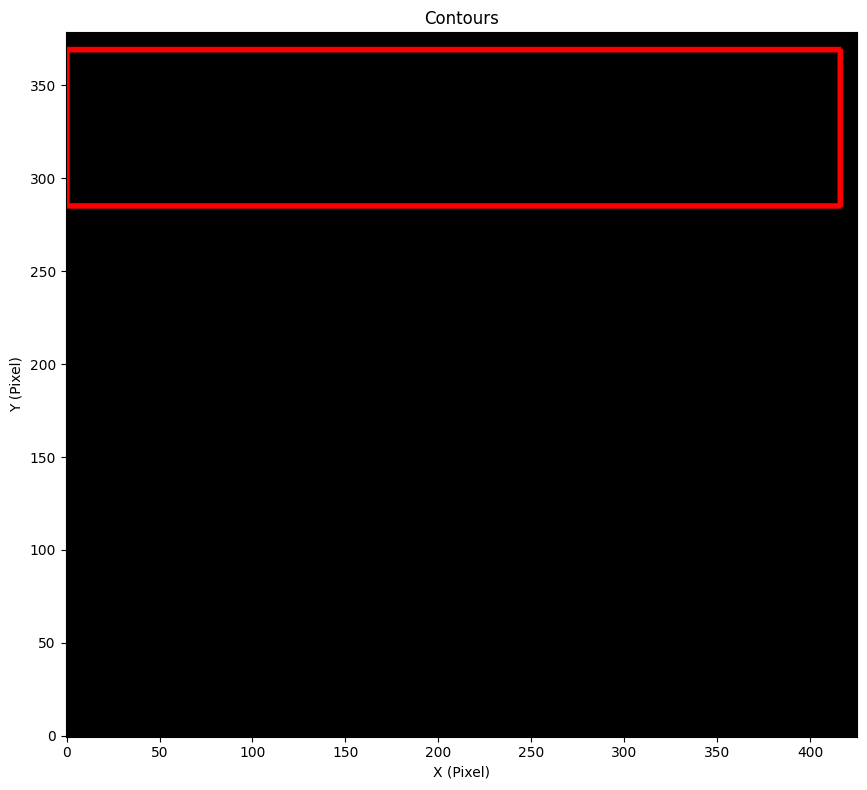

In [231]:
boundary_contours, _ = cv2.findContours(
    object_boundary,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_NONE  # NONE für vollständige Konturen (alle Pixel)
)

plot_contours(boundary_contours)

Initial contours: 4
After size filter: 4


(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Contours'}, xlabel='X (Pixel)', ylabel='Y (Pixel)'>)

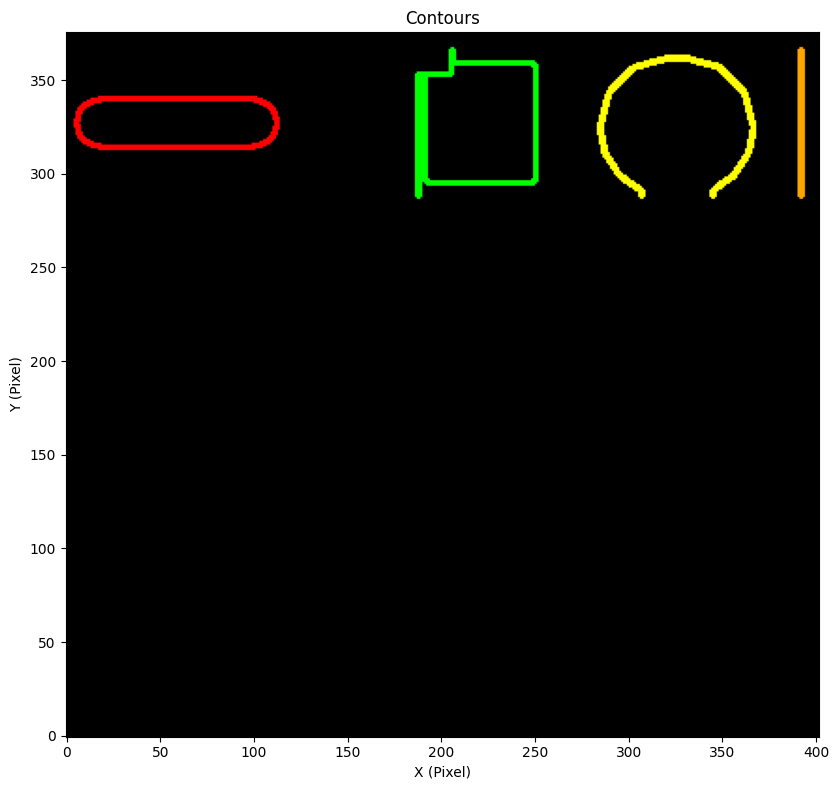

In [232]:

# Erkenne Konturen
contours, hierarchy = cv2.findContours(
    binary_image,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

print(f"Initial contours: {len(contours)}")

# Filtere kleine Konturen
min_contour_area = 20
filtered_contours = [c for c in contours if cv2.contourArea(c) >= min_contour_area]
print(f"After size filter: {len(filtered_contours)}")

plot_contours(contours)

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Contours'}, xlabel='X (Pixel)', ylabel='Y (Pixel)'>)

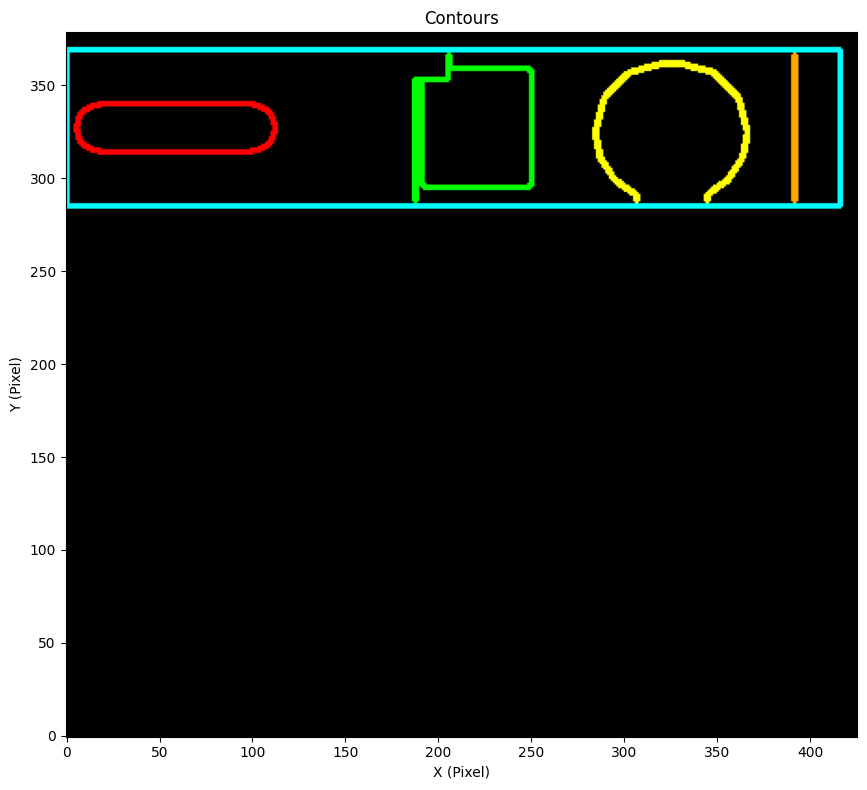

In [233]:
plot_contours(contours + boundary_contours)

## Schließe Kontouren mit Flood Fill

## 9. Filtere innere Konturen


=== Kontur 1 ===
  Start-Kontur-Pixel: (18, 314)
  Gradient-Richtung: (-0.00, 1.00)
  Innerer Punkt: (17, 319)
  FloodFill erfolgreich: 1 Kontur(en) gefunden

=== Kontur 2 ===
  Start-Kontur-Pixel: (391, 288)
  Gradient-Richtung: (1.00, 0.00)
  Innerer Punkt: (396, 288)
  FloodFill erfolgreich: 1 Kontur(en) gefunden

=== Kontur 3 ===
  Start-Kontur-Pixel: (306, 288)
  Gradient-Richtung: (1.00, 0.00)
  Innerer Punkt: (311, 288)
  FloodFill erfolgreich: 1 Kontur(en) gefunden

=== Kontur 4 ===
  Start-Kontur-Pixel: (187, 288)
  Gradient-Richtung: (1.00, 0.00)
  Innerer Punkt: (192, 288)
  FloodFill erfolgreich: 1 Kontur(en) gefunden
  === Gesamt: 4 gefüllte Konturen ===


(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'FloodFilled Contours'}, xlabel='X (Pixel)', ylabel='Y (Pixel)'>)

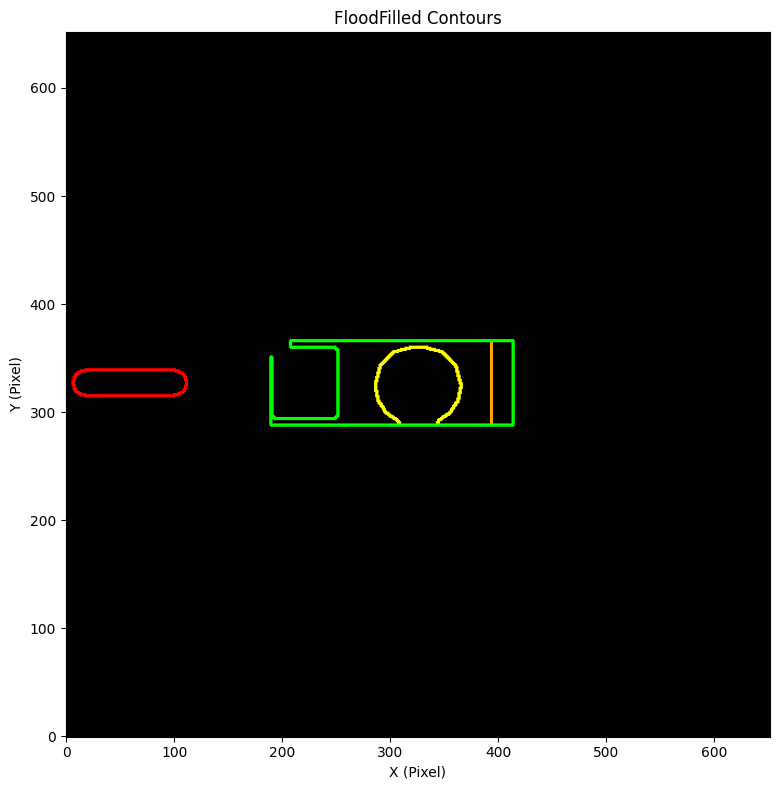

In [234]:
# FloodFill basierte Kontur-Schließung
# Ziel: Finde innere Pixel durch Gradient-Richtung und flute von dort aus

floodfilled_contours = []

for idx, contour in enumerate(filtered_contours):
    print(f"\n=== Kontur {idx+1} ===")
    
    # 1. Erstelle Maske mit Kontur
    contour_mask = np.zeros(binary_image.shape, dtype=np.uint8)
    cv2.drawContours(contour_mask, [contour], -1, 255, 1)
    
    # 2. Finde Startpunkt für FloodFill (innerer Punkt)
    # Strategie: Gehe von Kontur-Pixel in Richtung negativer Gradient (zur Innenseite)
    
    # Suche nach einem Kontur-Pixel als Ausgangspunkt
    contour_points = contour.squeeze()
    if len(contour_points.shape) == 1:
        print("  Überspringe: Ungültige Kontur")
        continue
    
    # Nimm ersten Kontur-Punkt
    start_x, start_y = contour_points[0]
    
    # Berechne Gradient an diesem Punkt
    gx = grad_x[start_y, start_x]
    gy = grad_y[start_y, start_x]
    
    # Normiere Gradient-Vektor
    grad_mag = np.sqrt(gx**2 + gy**2)
    if grad_mag > 0:
        gx_norm = -gx / grad_mag  # Negativ für Innenseite
        gy_norm = -gy / grad_mag
    else:
        # Fallback: Verwende Richtung zum Schwerpunkt
        M = cv2.moments(contour)
        if M['m00'] > 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            gx_norm = cx - start_x
            gy_norm = cy - start_y
            mag = np.sqrt(gx_norm**2 + gy_norm**2)
            if mag > 0:
                gx_norm /= mag
                gy_norm /= mag
            else:
                gx_norm, gy_norm = 0, 0
        else:
            gx_norm, gy_norm = 0, 0
    
    # Suche inneren Punkt (5 Pixel in Gradient-Richtung)
    search_dist = 5
    inner_x = int(start_x + gx_norm * search_dist)
    inner_y = int(start_y + gy_norm * search_dist)
    
    # Clipping auf Bildgrenzen
    inner_x = np.clip(inner_x, 0, binary_image.shape[1] - 1)
    inner_y = np.clip(inner_y, 0, binary_image.shape[0] - 1)
    
    print(f"  Start-Kontur-Pixel: ({start_x}, {start_y})")
    print(f"  Gradient-Richtung: ({gx_norm:.2f}, {gy_norm:.2f})")
    print(f"  Innerer Punkt: ({inner_x}, {inner_y})")
    
    # 3. FloodFill von innerem Punkt
    # Erstelle Maske: Kontur + Object Boundary = Barriere
    flood_barrier = np.zeros((binary_image.shape[0] + 2, binary_image.shape[1] + 2), dtype=np.uint8)
    flood_barrier[1:-1, 1:-1] = (contour_mask > 0) | (object_boundary > 0)
    
    # FloodFill Bild (beginne mit leerem Bild)
    flood_image = np.zeros(binary_image.shape, dtype=np.uint8)
    
    # Führe FloodFill aus
    cv2.floodFill(flood_image, flood_barrier, (inner_x, inner_y), 255)
    
    # 4. Extrahiere neue Kontur aus geflutetem Bereich
    flood_contours, _ = cv2.findContours(flood_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(flood_contours) > 0:
        # Nimm größte Kontur
        largest_flood = max(flood_contours, key=cv2.contourArea)
        floodfilled_contours.append(largest_flood)
        print(f"  FloodFill erfolgreich: {len(flood_contours)} Kontur(en) gefunden")
    else:
        # Fallback: Behalte Original-Kontur
        floodfilled_contours.append(contour)
        print(f"  Kein FloodFill-Ergebnis, behalte Original")

print(f"  === Gesamt: {len(floodfilled_contours)} gefüllte Konturen ===")

# Visualisiere gefüllte Konturen
plot_contours(floodfilled_contours, image_shape=binary_image.shape, title='FloodFilled Contours')

Konturen vor Filterung: 2
Konturen nach Filterung: 2


(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Final Outer Contours'}, xlabel='X (Pixel)', ylabel='Y (Pixel)'>)

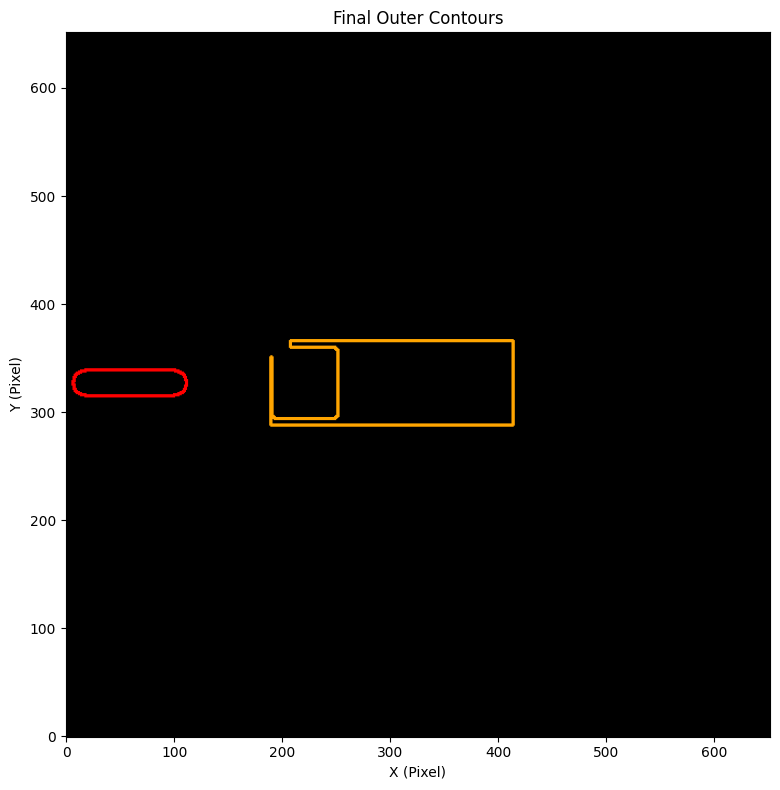

In [235]:
# Remove inner contours, only outer contours remain
# Erstelle Bild mit allen FloodFill-Konturen und finde Hierarchie

# Zeichne alle Konturen in ein Bild
all_contours_image = np.zeros(binary_image.shape, dtype=np.uint8)
for contour in floodfilled_contours:
    cv2.drawContours(all_contours_image, [contour], -1, 255, -1)  # Gefüllt

# Finde Konturen mit Hierarchie
final_contours, hierarchy = cv2.findContours(all_contours_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print(f"Konturen vor Filterung: {len(final_contours)}")

# Filtere verschachtelte Konturen (behalte nur äußere)
outer_contours = []
if hierarchy is not None:
    hierarchy = hierarchy[0]  # OpenCV gibt [1, N, 4] array zurück
    for i, contour in enumerate(final_contours):
        # Hierarchie: [Next, Previous, First_Child, Parent]
        # Parent == -1 bedeutet äußere Kontur (keine Parent)
        parent = hierarchy[i][3]
        if parent == -1:
            outer_contours.append(contour)
else:
    # Keine Hierarchie -> alle sind äußere Konturen
    outer_contours = final_contours

print(f"Konturen nach Filterung: {len(outer_contours)}")

# Visualisiere
plot_contours(outer_contours, image_shape=binary_image.shape, title='Final Outer Contours')

## 11. Berechne Chamber Center

In [236]:
# Berechne Chamber Center
chamber_center = calculate_chamber_center_for_point(
    cp,
    final_contours,
    depth_image,
    extent,
    direction_vector
)

if chamber_center['chamber_center'] is not None:
    cc = chamber_center['chamber_center']
    print(f"Chamber Center found:")
    print(f"  X: {cc['X']:.4f}")
    print(f"  Y: {cc['Y']:.4f}")
    print(f"  Z: {cc['Z']:.4f}")
else:
    print("No chamber center found")

  Connection point pixel: (325, 325)
  Chamber center: (5.3907, 19.0284, -2.0906)
Chamber Center found:
  X: 5.3907
  Y: 19.0284
  Z: -2.0906


## 12. Finale Analyse Visualisierung

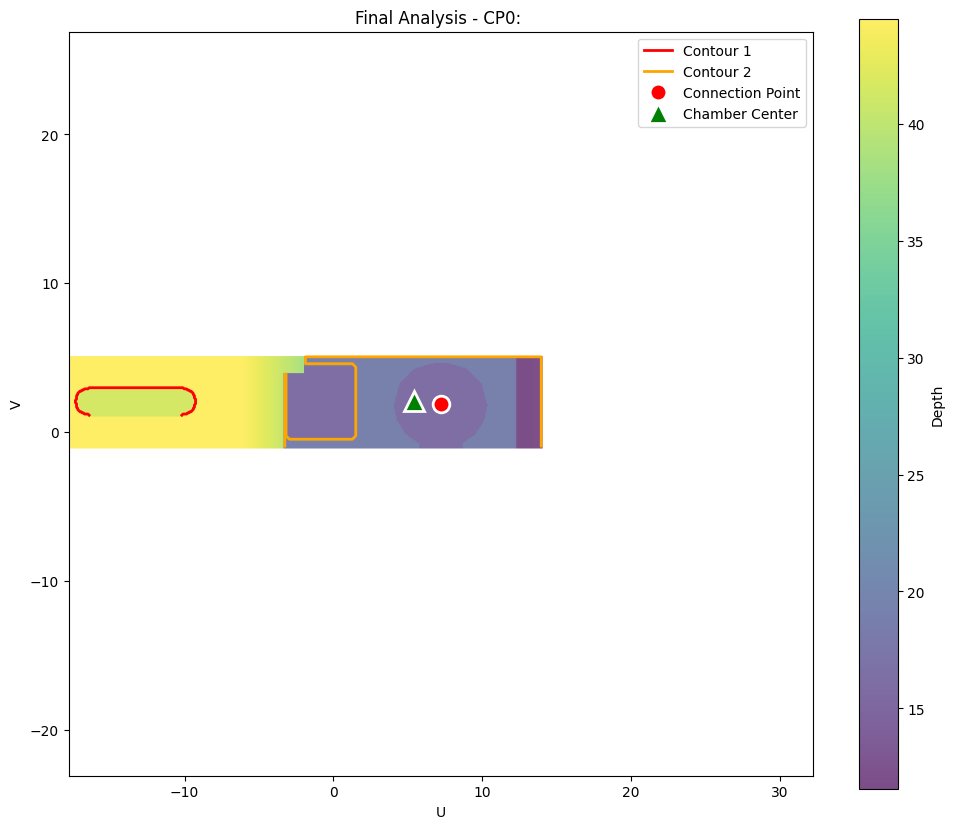

In [237]:
# Erstelle finale Visualisierung
depth_display = np.ma.masked_invalid(depth_image)

u_min, u_max, v_min, v_max = extent_tuple
u_axis = transform_info['u_axis']
v_axis = transform_info['v_axis']
voxel_size = transform_info['voxel_size']

# Connection Point Position in U/V
cp_point = cp['Point']
cp_world = np.array([cp_point['X'], cp_point['Y'], cp_point['Z']])
cp_u = np.dot(cp_world, u_axis)
cp_v = np.dot(cp_world, v_axis)

# Chamber Center Position
cc_u, cc_v = None, None
if chamber_center.get('chamber_center') is not None:
    cc = chamber_center['chamber_center']
    cc_world = np.array([cc['X'], cc['Y'], cc['Z']])
    cc_u = np.dot(cc_world, u_axis)
    cc_v = np.dot(cc_world, v_axis)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(depth_display, extent=extent_tuple, origin='lower', cmap='viridis', alpha=0.7)
im.cmap.set_bad(color='white')
plt.colorbar(im, ax=ax, label='Depth')

# Zeichne Konturen
colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'magenta', 'pink']
for i, contour in enumerate(final_contours):
    contour_squeezed = contour.squeeze()
    if len(contour_squeezed.shape) == 1:
        continue

    contour_u = u_min + contour_squeezed[:, 0] * voxel_size
    contour_v = v_min + contour_squeezed[:, 1] * voxel_size

    color = colors[i % len(colors)]
    ax.plot(contour_u, contour_v, color=color, linewidth=2, label=f'Contour {i+1}')

# Zeichne Connection Point
ax.plot(cp_u, cp_v, 'ro', markersize=12, markeredgecolor='white', markeredgewidth=2, zorder=10, label='Connection Point')

# Zeichne Chamber Center
if cc_u is not None and cc_v is not None:
    ax.plot(cc_u, cc_v, 'g^', markersize=14, markeredgecolor='white', markeredgewidth=2, zorder=10, label='Chamber Center')

ax.set_xlabel('U')
ax.set_ylabel('V')
ax.set_title(f'Final Analysis - CP{cp["Index"]}: {cp["Name"]}')
ax.legend()
plt.show()